# Задание 3

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

# Данные

##### Ссылка: https://www.kaggle.com/datasets/vbmokin/dissolved-oxygen-prediction-in-river-water
В качестве признака выбран показатель O2 на первой станции, измеряющей качество воды в реке (состоит из средних по месяцу значений, измеряется в миллиграммах кислорода на квадратный дециметр)

In [2]:
url = 'https://drive.google.com/uc?id=1xaVohB2RWa9hI1L7lkXcaTaRkymVPeMa'

In [3]:
data = pd.read_excel(url, engine='openpyxl', index_col='Id')
data = data.dropna()

In [4]:
data.head(5) # первые 5 значений показателя 

,O2_1
Id,
0,9.875
3,10.300
4,8.290
5,8.820
6,6.000


In [5]:
data.shape # размерность данных

(145, 1)

---

# Функции для рассчета описательных статистик и удаления выбросов

In [6]:
def location_and_spread(data):
    counts = {}
    for i in data.iloc[:,0]:
        counts[i] = counts.get(i, 0) + 1
    max_count = max(counts.values())
    sorted_data = sorted(data.iloc[:,0])
    length = len(data)

    Mean = round(sum(data.iloc[:,0])/len(data), 2)
    Mode = [round(k, 2) for k, v in counts.items() if v == max_count]
    if length % 2 == 0:
        Median = round((sorted_data[length//2] + sorted_data[length//2-1]) / 2, 2)
    else:
        Median = round(sorted_data[length//2], 2)
    
    D = round(sum([(t - Mean)**2 / (len(data)-1) for t in data.iloc[:,0]]), 2)
    std = round(D**(1/2), 2)
    
    print(f"Mean: {Mean}\nMode: {Mode}\nMedian: {Median}\nVariance: {D}\nStd: {std}")

In [7]:
def remove_outliers(data):
    q_75 = np.percentile(data, 75)
    q_25 = np.percentile(data, 25)
    IQR = q_75 - q_25
    upper_limit = q_75 + IQR*1.5
    lower_limit = q_25 - IQR*1.5
    data = data[(data.iloc[:,0] >= lower_limit) & (data.iloc[:,0] <= upper_limit)]
    if min(data.iloc[:,0]) < lower_limit or max(data.iloc[:,0]) > upper_limit:
        data = remove_outliers(data)
    return data

In [8]:
location_and_spread(data) # значения статистик 

Mean: 9.17
Mode: [9.1, 8.7]
Median: 8.7
Variance: 17.54
Std: 4.19


---

# Графики на основе исходных данных и удаление выбросов

Построим гистограммы распределения, ящики с усами и графики ядерной оценки плотности для исходных данных и для данных с убранными выбросами.

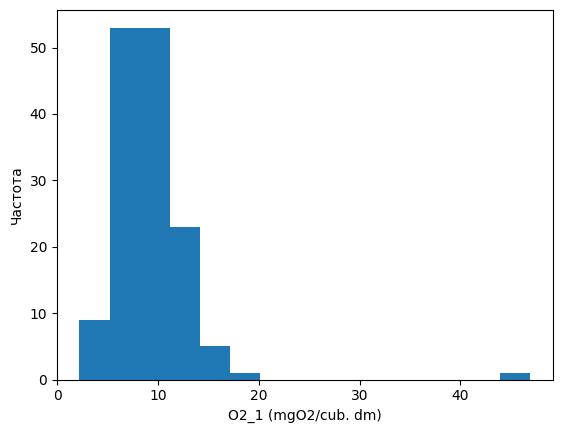

In [9]:
plt.hist(data, bins=15)
plt.title("Исходные данные")
plt.ylabel("Частота")
plt.xlabel("O2_1 (mgO2/cub. dm)")
plt.show()

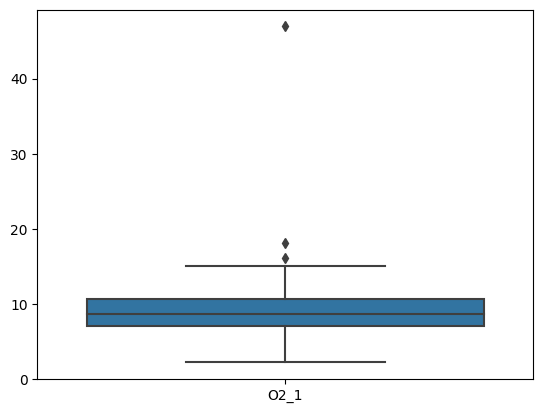

In [10]:
sns.boxplot(data)
plt.title("Исходные данные")
plt.show()

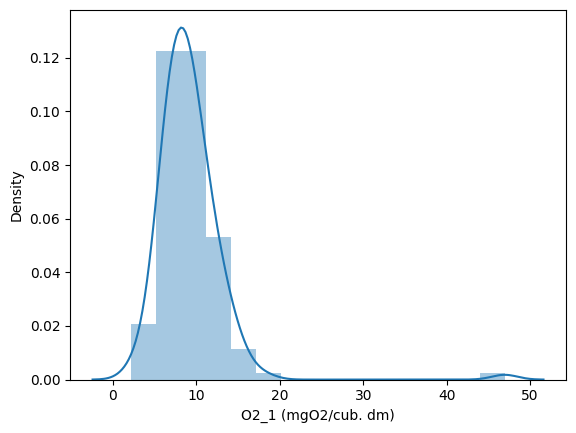

In [11]:
sns.distplot(data, bins=15)
plt.title("Исходные данные")
plt.xlabel("O2_1 (mgO2/cub. dm)")
plt.show()

In [12]:
stats.skew(data)# выборочная ассиметрия

array([5.17353259])

In [13]:
data = remove_outliers(data)# удаление выбросов

In [14]:
location_and_spread(data)# значения статистик

Mean: 8.79
Mode: [9.1, 8.7]
Median: 8.68
Variance: 6.75
Std: 2.6


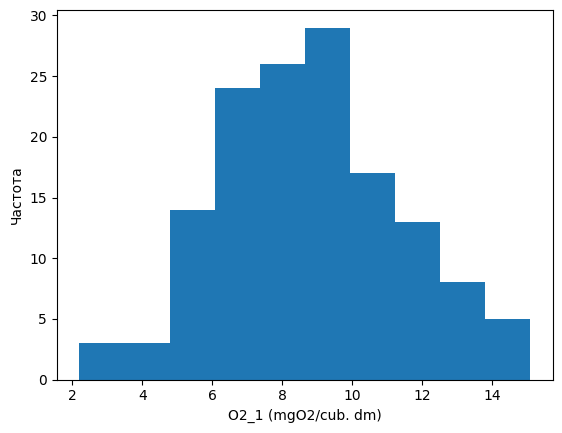

In [15]:
plt.hist(data)
plt.title("Данные без выбросов")
plt.ylabel("Частота")
plt.xlabel("O2_1 (mgO2/cub. dm)")
plt.show()

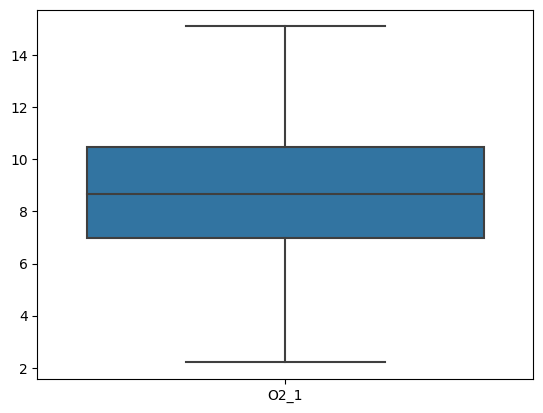

In [16]:
sns.boxplot(data)
plt.title("Данные без выбросов")
plt.show()

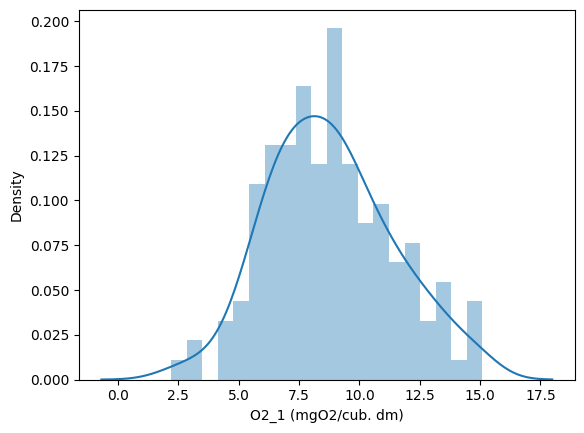

In [17]:
sns.distplot(data, bins=20)
plt.title("Данные без выбросов")
plt.xlabel("O2_1 (mgO2/cub. dm)")
plt.show()

In [18]:
stats.skew(data)# выборочная ассиметрия

array([0.26883496])

---

# Гипотезы о распределении исходных данных

Далее проверим некоторые гипотезы о распределении наших данных.

In [19]:
X = np.linspace(min(data.iloc[:,0]), max(data.iloc[:,0]), 100)# задаем область определения
mean = data.iloc[:, 0].mean()
var = data.iloc[:, 0].var()
std = data.iloc[:, 0].std()

## Нормальное распределение

Оценка параметров:
- $\hat{μ} = 8.79$
- $\hat{σ} = 2.60$

In [20]:
stats.norm.fit(data.iloc[:,0], method='MM')# параметры распределения, полученные методом моментов

(8.79107981220657, 2.5883096489215562)

In [21]:
norm_params = (8.79107981220657, 2.5883096489215562)

In [22]:
y_pdf = stats.norm.pdf(X, mean, std)# считаем значения плотности вероятности нормального распределения

[]

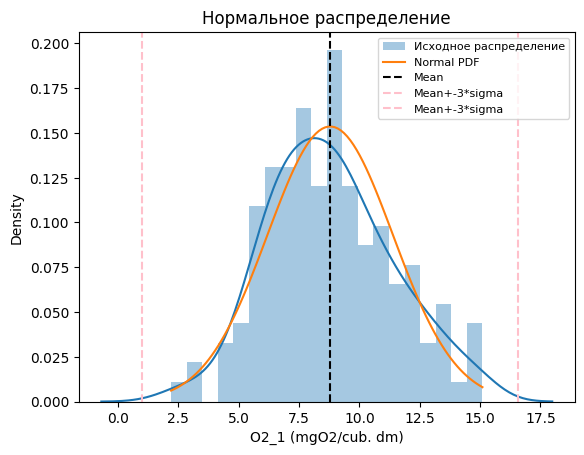

In [23]:
sns.distplot(data, bins=20, label='Исходное распределение')
plt.plot(X, y_pdf, label='Normal PDF')
plt.axvline(label='Mean', x=mean, linestyle='dashed', color='black')
plt.axvline(label='Mean+-3*sigma', x=mean+3*std, linestyle='dashed', color='pink')
plt.axvline(label='Mean+-3*sigma', x=mean-3*std, linestyle='dashed', color='pink')
plt.title("Нормальное распределение")
plt.xlabel("O2_1 (mgO2/cub. dm)")
plt.legend(loc='upper right', fontsize=8)
plt.plot()

## Гамма распределение

Оценка параметров:
- $k=\frac{E[X]^2}{Var[X]} => \hat{k}=11.45$
- $\theta=\frac{Var[X]}{E[X]} => \hat{\theta}=0.77$

In [24]:
stats.gamma.fit(data.iloc[:,0], method='MM')# параметры распределения, полученные методом моментов

(55.34628041354775, -10.464670724252107, 0.3479140855099853)

In [25]:
gamma_params = (55.34628041354775, -10.464670724252107, 0.3479140855099853)

В библиотеке stats параметры гамма распределения представляют из себя набор из 3-х значений: форма, смещение и масштаб. Для сравнения рассчитаем значения плотности вероятности гамма распределения через 2 оцененных параметра. 

In [26]:
y_gamma_pdf_est = stats.gamma.pdf(X, a=mean**2/var, scale=var/mean)# задание распределения через 2 параметра

In [45]:
y_gamma_pdf = stats.gamma.pdf(X, *stats.gamma.fit(data.iloc[:,0], method='MM'))# считаем значения плотности вероятности гамма распределения

[]

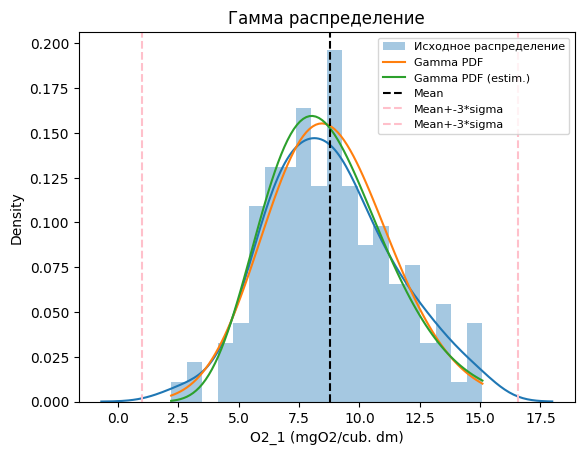

In [28]:
sns.distplot(data, bins=20, label='Исходное распределение')
plt.plot(X, y_gamma_pdf, label='Gamma PDF')
plt.plot(X, y_gamma_pdf_est, label='Gamma PDF (estim.)')
plt.axvline(label='Mean', x=mean, linestyle='dashed', color='black')
plt.axvline(label='Mean+-3*sigma', x=mean+3*std, linestyle='dashed', color='pink')
plt.axvline(label='Mean+-3*sigma', x=mean-3*std, linestyle='dashed', color='pink')
plt.title("Гамма распределение")
plt.xlabel("O2_1 (mgO2/cub. dm)")
plt.legend(loc='upper right', fontsize=8)
plt.plot()

## Логистическое распределение

Оценка параметров:
- $\hat{μ} = 8.79$
- $\hat{s} = 2.60*\frac{\sqrt{3}}{\pi}$

In [29]:
import math
std * math.sqrt(3)/math.pi

1.4320612780224498

In [46]:
stats.logistic.fit(data.iloc[:,0], method='MM')# параметры распределения, полученные методом моментов

(8.79107981220657, 1.427009899749488)

In [31]:
logistic_params = (8.79107981220657, 1.427009899749488)

In [32]:
y_logistic_pdf = stats.logistic.pdf(X, *stats.logistic.fit(data.iloc[:,0], method='MM'))# считаем значения плотности вероятности логистического распределения

[]

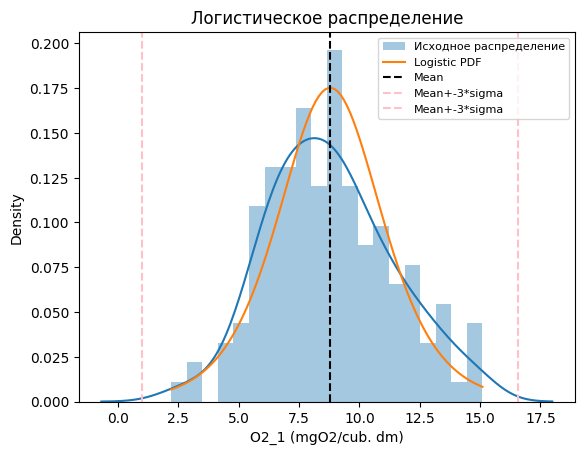

In [33]:
sns.distplot(data, bins=20, label='Исходное распределение')
plt.plot(X, y_logistic_pdf, label='Logistic PDF')
plt.axvline(label='Mean', x=mean, linestyle='dashed', color='black')
plt.axvline(label='Mean+-3*sigma', x=mean+3*std, linestyle='dashed', color='pink')
plt.axvline(label='Mean+-3*sigma', x=mean-3*std, linestyle='dashed', color='pink')
plt.title("Логистическое распределение")
plt.xlabel("O2_1 (mgO2/cub. dm)")
plt.legend(loc='upper right', fontsize=8)
plt.plot()

## Общий график

[]

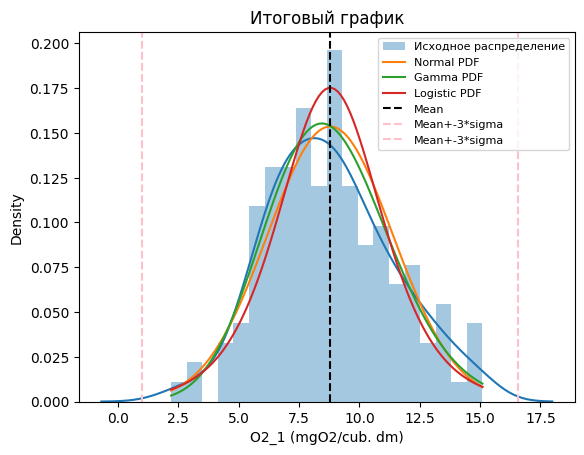

In [34]:
sns.distplot(data, bins=20, label='Исходное распределение')
plt.plot(X, y_pdf, label='Normal PDF')
plt.plot(X, y_gamma_pdf, label='Gamma PDF')
plt.plot(X, y_logistic_pdf, label='Logistic PDF')
plt.axvline(label='Mean', x=mean, linestyle='dashed', color='black')
plt.axvline(label='Mean+-3*sigma', x=mean+3*std, linestyle='dashed', color='pink')
plt.axvline(label='Mean+-3*sigma', x=mean-3*std, linestyle='dashed', color='pink')
plt.title("Итоговый график")
plt.xlabel("O2_1 (mgO2/cub. dm)")
plt.legend(loc='upper right', fontsize=8)
plt.plot()

---

# Проверка гипотез с помощью критерия Хи-квадрат

In [35]:
def expected_value(distrib_name, params, data_length, cat_num, interval_cats): # ожидаемое число попаданий в интервал
    expected = []
    method = getattr(stats, distrib_name)
    distrib = method(*params)
    for i in range(cat_num):
        E = (data_length*(distrib.cdf(interval_cats[i].right) - distrib.cdf(interval_cats[i].left))).round().astype(np.int64)
        expected.append(E)
        print(f'В {i} интервал попадет: {E} значений')
    
    return expected

In [36]:
def chi_squared(expected, intervals): # статистика Хи-квадрат
    chi = 0
    for i in range(cat_num):
        emp = intervals.value_counts(sort=False).iloc[i]
        exp = expected[i]
        chi += ((emp - exp)**2)/exp
        
    return chi   

In [37]:
cat_num = 10 # кол-во интервалов
intervals = pd.qcut(data.O2_1, cat_num) # деление данных на интервалы
interval_cats = intervals.cat.categories # полученные граничные значения (10 пар)

## Гипотеза №1
Выборка $X^n$ порождается функцией *нормального* распределения: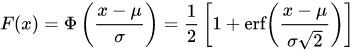
Уровень значимости $\alpha=0.05$

In [38]:
expected_norm = expected_value('norm', norm_params, data.shape[0], cat_num, interval_cats) # ожидается

В 0 интервал попадет: 18 значений
В 1 интервал попадет: 9 значений
В 2 интервал попадет: 13 значений
В 3 интервал попадет: 10 значений
В 4 интервал попадет: 18 значений
В 5 интервал попадет: 9 значений
В 6 интервал попадет: 17 значений
В 7 интервал попадет: 19 значений
В 8 интервал попадет: 17 значений
В 9 интервал попадет: 10 значений


In [39]:
stats.distributions.chi2.sf(chi_squared(expected_norm, intervals), cat_num-1) # расчет p-значения

0.06135111004241766

$p=0.06 > \alpha=0.05$

### Отклонить гипотезу о нормальности распределения данных нельзя

## Гипотеза №2
Выборка $X^n$ порождается функцией *гамма* распределения: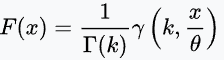
Уровень значимости $\alpha=0.05$

In [40]:
expected_gamma = expected_value('gamma', gamma_params, data.shape[0], cat_num, interval_cats) # ожидается

В 0 интервал попадет: 18 значений
В 1 интервал попадет: 10 значений
В 2 интервал попадет: 14 значений
В 3 интервал попадет: 11 значений
В 4 интервал попадет: 18 значений
В 5 интервал попадет: 9 значений
В 6 интервал попадет: 17 значений
В 7 интервал попадет: 17 значений
В 8 интервал попадет: 16 значений
В 9 интервал попадет: 10 значений


In [41]:
stats.distributions.chi2.sf(chi_squared(expected_gamma, intervals), cat_num-1) # расчет p-значения

0.16264755556725735

$p=0.16 > \alpha=0.05$

### Отклонить гипотезу о том, что данные подчиняются гамма распределению, нельзя

## Гипотеза №3
Выборка $X^n$ порождается функцией *логистического* распределения: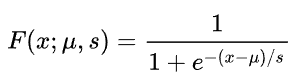
Уровень значимости $\alpha=0.05$

In [42]:
expected_logistic = expected_value('logistic', logistic_params, data.shape[0], cat_num, interval_cats) # ожидается

В 0 интервал попадет: 15 значений
В 1 интервал попадет: 8 значений
В 2 интервал попадет: 13 значений
В 3 интервал попадет: 11 значений
В 4 интервал попадет: 20 значений
В 5 интервал попадет: 11 значений
В 6 интервал попадет: 19 значений
В 7 интервал попадет: 19 значений
В 8 интервал попадет: 15 значений
В 9 интервал попадет: 9 значений


In [43]:
stats.distributions.chi2.sf(chi_squared(expected_logistic, intervals), cat_num-1) # расчет p-значения

0.041777841342813773

$p=0.04 < \alpha=0.05$

### Отклоняем гипотезу о том, что данные подчиняются логистическому распределению

# Вывод:
Нормальное и гамма распределения хорошо описывают выборочные данные. При этом наибольшую вероятность имеет нулевая гипотеза о гамма распределении данных. Для более надежных выводов о распределении данных можно исследовать другие распределения и получить большее количество данных.